# Data Scientist Nanodegree Project1: Write A Data Science Blog Post

In this noteook, I analyse the Stack Overflow Data - 2017 Survey dataset. The data is available at: https://www.kaggle.com/datasets/stackoverflow/so-survey-2017
The motivation of this dataset is to understand the various factors that determine the salary of this dataset.
I follow the CRISP-DM(Cross-Industry Standard Process for Data Mining) methodology, which consists of the following steps:
1. Business Understanding
2. Data Understanding
3. Prepare Data
4. Data Modeling
5. Evaluation

# 1.Business Understanding

Every year, Stack Overflow conducts a massive survey of people on the site, covering all sorts of information like programming languages, salary, code style and various other information. In 2017, they amassed more than 64,000 responses fielded from 213 countries.

# 2.Data Understanding

I read survey results by pandas, and check columns names and each values.
Columns such as 'Salary', 'Professional', 'Country', include NaN and non-numeric values. These Nan and categorical variables are neccesarily cleaned for  LinearRegression.
And, I have 3 questions below:
1. Who get high salaries?
2. Why do they get high salaries?
3. How do they get high salaries?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

%matplotlib inline

df = pd.read_csv('./stack-overflow-developer-survey-2017/survey_results_public.csv')
df

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51387,51388,Professional developer,"Yes, I program as a hobby",United States,No,Employed full-time,Bachelor's degree,A social science,A few days each month,100 to 499 employees,...,Disagree,Male,A doctoral degree,East Asian; White or of European descent,Disagree,Agree,Strongly disagree,Strongly agree,58000.0,NaN
51388,51389,Student,No,Venezuela,"Yes, full-time",Employed full-time,Master's degree,Computer programming or Web development,Never,100 to 499 employees,...,NaN,Male,A master's degree,Black or of African descent; Hispanic or Latin...,Somewhat agree,Agree,Disagree,Agree,NaN,NaN
51389,51390,Professional developer,"Yes, I program as a hobby",Canada,No,Employed full-time,Some college/university study without earning ...,"Information technology, networking, or system ...","Less than half the time, but at least one day ...",10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51390,51391,Professional developer,"Yes, I program as a hobby",United States,No,Employed full-time,Bachelor's degree,Computer science or software engineering,Never,Fewer than 10 employees,...,Disagree,Male,A bachelor's degree,White or of European descent,Disagree,Agree,Disagree,Strongly agree,40000.0,NaN


In next time, I checked histograms and a heatmap of each columns for data distributuins and correlations. 
In histograms, it is interesting that CareerSatisfaction and Jobsatisfaction are higher, the frequencies are higher. In reverse, Salary and ExpectedSalary are higher, the frequencies are lower. This shows that many respondents are satisfied by their careers and jobs in spite of their salaries.
In the heatmap, impressively, satisfactions are positive correlated to salaries against histograms.

array([[<AxesSubplot:title={'center':'Respondent'}>,
        <AxesSubplot:title={'center':'CareerSatisfaction'}>,
        <AxesSubplot:title={'center':'JobSatisfaction'}>],
       [<AxesSubplot:title={'center':'HoursPerWeek'}>,
        <AxesSubplot:title={'center':'StackOverflowSatisfaction'}>,
        <AxesSubplot:title={'center':'Salary'}>],
       [<AxesSubplot:title={'center':'ExpectedSalary'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

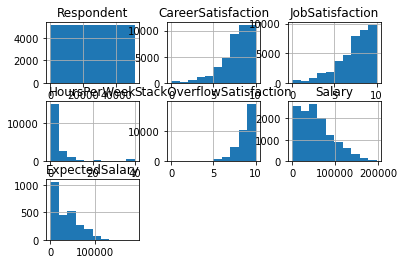

In [2]:
df.hist()

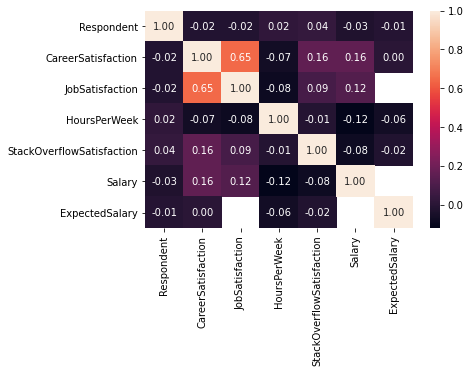

In [3]:
sns.heatmap(df.corr(), annot=True, fmt=".2f");

# 3. Prepare Data
At first, it is neccesary to drop NaN of 'Salary'. 'Respondent' is ID and unnecessay to predict Salary. Then, categorical variables are necesary to be changed to numeric variables for  LinearRegression. 

In [4]:
def clean_data(df):
    '''
    Obtain the correct X and y objects
    
    INPUT:
    df - a dataframe holding all the variables of interest
    
    OUTPUT:
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vecto

    '''
    #Drop all the rows with no salaries
    df = df.dropna(subset=['Salary'], axis=0)
    #Create X as all the columns that are not the Salary column
    X = df.drop('Salary', axis=1)
    #Create y as the Salary columns
    y = df['Salary']
    #Drop the Salary, Respondent, and the ExpectedSalary columns from X
    X = X.drop(['Respondent', 'ExpectedSalary'], axis=1)
    #For each numeric variable in X, fill the column with the mean value of the column
    num_vars = X.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        X[col].fillna((X[col].mean()), inplace=True)
    #Create dummy columns for all the categorical variables in X, drop the original columns
    cat_vars = X.select_dtypes(include=['object']).copy().columns
    for col in cat_vars:
        X = pd.concat([X.drop(col, axis=1), pd.get_dummies(X[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
        
    return X, y

X, y = clean_data(df)    

# 4. Data Modeling
I predict Salary from other variables. For training and prediction, LinearRegression of Scikit-Learn is used. 
Train r2 score and Test r2 score are enough high, Data Modeling is shown to be successful.

In [5]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    
    Fit and predict by lm_model of scikit-learn  prefenrentially with more values X.
    
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test


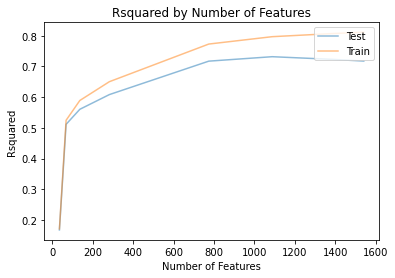

In [6]:
#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]

r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

# 5. Evaluation
The results of coefficients reflect the average Salary of Country, because US of the best average is the highest and other coutries making the top 10 of Salary are higher. Top 4 of Swiss francs reflects the high average of Swiss. 
In other hand, experiences are important for high Salary, too. More than 19 years of Coded Job is the higest Salary anod all of more than 11 years are high.
The answers of 3 questions above are below:


## Question1.Who get high salaries?
## Answer:
People who have experienced coded jobs more than 12 years in US. 

The result of coef_weights below show that  US is the best of Country, and all of more than 12 coded Job years are included in Top 20.


## Question2. Why do they get high salaries?
## Answer: 
Because the average salary of US is the best in the world.

Below is ranking of the average salary. Switzerland, Norway, US, Denmark, Iceland are in Top 10. Because the average salary of these countries, it seems that Coded Job is similarly high.

## Question3. How do they get high salaries?
## Answer:
By having experinced coded jobs more than 12 in US. Experiences are valued more than anything in coded jobs.



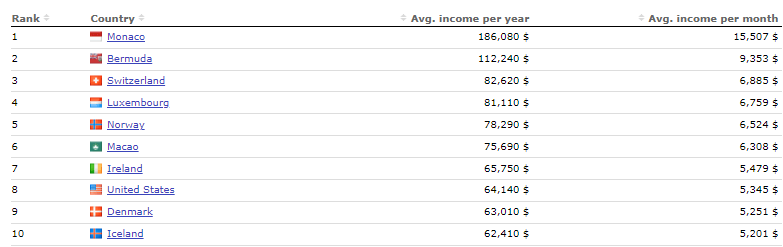

In [7]:
def coef_weights(coefficients, X_train):
    '''
    Return a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

coef_df = coef_weights(lm_model.coef_, X_train)

coef_df.head(20)

,est_int,coefs,abs_coefs
42,Country_United States,56731.283619,56731.283619
28,Country_Norway,40550.628110,40550.628110
8,Country_Australia,40111.916279,40111.916279
383,Currency_Swiss francs,36748.955151,36748.955151
15,Country_Denmark,30497.628811,30497.628811
123,YearsCodedJob_20 or more years,29980.868555,29980.868555
27,Country_New Zealand,29954.315738,29954.315738
23,Country_Israel,29510.172957,29510.172957
13,Country_Canada,29363.254074,29363.254074
22,Country_Ireland,28551.627756,28551.627756


##### 